<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Demo: CNN with Keras
INSTRUCTIONS:
- Run the cells
- Observe and understand the results
- Answer the questions

## Faces classification with Keras

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Import libraries

In [1]:
## Import libraries
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import confusion_matrix

# import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.utils import to_categorical

Using TensorFlow backend.


## Load data

In [11]:
# The faces dataset
faces = fetch_olivetti_faces()
faces

{'data': array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
         0.1570248 ],
        [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
         0.15289256],
        [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
         0.15289256],
        ...,
        [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
         0.19008264],
        [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
         0.60330576],
        [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
         0.38429752]], dtype=float32),
 'images': array([[[0.30991736, 0.3677686 , 0.41735536, ..., 0.37190083,
          0.3305785 , 0.30578512],
         [0.3429752 , 0.40495867, 0.43801653, ..., 0.37190083,
          0.338843  , 0.3140496 ],
         [0.3429752 , 0.41735536, 0.45041323, ..., 0.38016528,
          0.338843  , 0.29752067],
         ...,
         [0.21487603, 0.20661157, 0.2231405 , ..., 0.15289256,
     

In [3]:
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

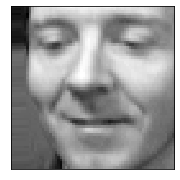

In [9]:
id = np.random.randint(len(faces.target))
plt.figure(figsize = (3, 3))
plt.imshow(faces.images[id], cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
# Prepare input data
# input
X = faces.images
img_rows, img_cols = X[0].shape
X = X.reshape(X.shape[0], img_rows, img_cols, 1)

# output
target = faces.target.astype(np.uint8)

# Convert the target to categorical
y = to_categorical(
    target,
    num_classes = len(set(target)),
    dtype = 'uint8')

In [0]:
filter = []
# run in blocks of 10
for i in range(len(target) // 10):
    s = set()
    while len(s) < 2:
        s = set(np.random.randint(0, 10, 2, dtype = np.int8))
    a = [x in s for x in range(10)]
    filter.append(a)
test = np.array(filter).flatten()
train = np.array([not t for t in test])

In [0]:
X_train = X[train].copy()
X_test  = X[test].copy()
y_train = y[train].copy()
y_test  = y[test].copy()

In [0]:
# Set up the model architecture
model = Sequential()

In [0]:
# Add a convolutional layer
model.add(Conv2D(60,
                 kernel_size = 4,
                 activation = 'relu',
                 data_format = 'channels_last',
                 padding = 'valid',
                 input_shape = (img_rows, img_cols, 1)))

# Add another convolutional layer
model.add(Conv2D(30,
                 kernel_size = 2,
                 activation = 'relu'))

# Flatten the output of the convolutional layer
model.add(Flatten())

# Add an output layer for the 3 categories
model.add(Dense(len(set(target)),
                activation = 'softmax'))

In [0]:
print(model.summary())

In [0]:
# Compile the model 
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [0]:
%%time
# Fit the model on a training set
history = model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    epochs = 9,
    batch_size = 10)

In [0]:
predictions = model.predict_classes(X_test)

In [0]:
score = model.evaluate(X_test, y_test, batch_size = 10)
print('\nTest loss: %.6f, Test accuracy: %.6f' % tuple(score))

In [0]:
def print_cm(cm):
    d_size = max(len('%d' % cm.max()), len('%d' % cm.shape[1]))
    if min(cm.shape) > 10: # make sparse
        print('Sparse Matrix (*=diagonal)')
        fmt_r = 'r%%0%dd' % d_size
        fmt_c = ', c%%0%dd%%s= %%%dd' % (d_size, d_size)
        for i in range(cm.shape[0]):
            s = fmt_r % i
            for j in range(cm.shape[1]):
                if cm[i, j] > 0:
                    s += fmt_c % (j, '*' if i == j else ' ', cm[i, j])
            print(s)
    else: # make dense
        c = '%%%dd ' % d_size
        s = '%s| ' % (' ' * d_size)
        s += ''.join([c % i for i in range(len(cm[0]))])
        print(s)
        print('-' * len(s))
        for i, r in enumerate(cm):
            s = '%2d| ' % i
            s += c * len(r)
            print(s % tuple(r))

In [0]:
y_test_target = np.array([x.argmax() for x in y_test])
cm = confusion_matrix(y_test_target, predictions)
print_cm(cm)

In [0]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(model.history.history['acc'])
ax[0].plot(model.history.history['val_acc'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'])

# Plot training & validation loss values
ax[1].plot(model.history.history['loss'])
ax[1].plot(model.history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'])

plt.show()

In [0]:
def implot2(im1, im2, id):
    t1 = y_test[id].argmax()
    t2 = predictions[id]

    fig, ax = plt.subplots(1, 2, figsize = (6, 3))
    fig.subplots_adjust(left = 0.02, right = 0.98, top = 0.85, wspace = 0.2)
    fig.suptitle('Prediction %d' % id, fontsize = 12, fontweight = 'bold')

    plt.rcParams.update({'font.size': 10})

    # original image
    ax[0].imshow(im1, cmap = 'gray')
    ax[0].set_title('Original id: %d' % t1)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # convoluted image
    ax[1].imshow(im2, cmap = 'gray')
    ax[1].set_title('Test id: %d' % t2)
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.show()

In [0]:
def pick_test_image(pid):
    # pick the prediction
    ppid = predictions[pid]
    # find the corresponding image
    j = -1
    for ipid in range(test.shape[0]):
        if test[ipid]:
            j += 1
        if j == pid:
            break
    return X[ipid].reshape(img_rows, img_cols)

In [0]:
def pick_train_image(ppid):
    oid = np.array([a.argmax() == ppid for a in y_train]).argmax()
    poid = y_train[oid].argmax()
    j = -1
    for ioid in range(train.shape[0]):
        if train[ioid]:
            j += 1
        if j == oid:
            break
    return X[ioid].reshape(img_rows, img_cols)

In [0]:
def compare_images(id):
    XTest = pick_test_image(id)
    XTrain = pick_train_image(predictions[id])
    implot2(XTrain, XTest, id)

In [0]:
# compare one
id = np.random.randint(len(predictions))
compare_images(id)

In [0]:
# compare ten
ids = np.random.randint(len(predictions), size = 10)
for id in ids:
    compare_images(id)

>

>

>



---



---



> > > > > > > > > © 2019 Institute of Data


---



---



